#  Прогнозирование заказов такси

**Постановка задачи**

Служба заказа собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

**План работы**

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

## Подготовка

In [1]:
!pip install phik -q
!pip install termcolor -q

In [2]:
import pandas as pd
import numpy  as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import table
import phik
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import root_mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from termcolor import colored
import lightgbm as lgb
from catboost import Pool, cv, CatBoostRegressor
from sklearn.inspection import permutation_importance

In [3]:
random_fix = 12345                          # фиксируем константу для последующего применения в random_state
pd.set_option('display.max_colwidth', None) # установка максимальной ширины ячейки в таблице pandas

In [4]:
# загрузка данных с учётом различных локаций исходного файла
try:
    data = pd.read_csv('../../20 временные ряды/project/taxi.csv', index_col='datetime', parse_dates=['datetime'])
except:
    try:
        data = pd.read_csv('/datasets/taxi.csv', index_col='datetime', parse_dates=['datetime'])
    except:
        data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col='datetime', parse_dates=['datetime'])

In [5]:
data.head(3)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [7]:
data.index.is_monotonic_increasing # проверка, отсортированы ли в хронологическом порядке индексы

True

In [8]:
data = data.resample('1H').sum() # ресемплирование df по одному часу

В исходном датасете 26496 временных рядов. Индекс в формате DatetimeIndex уже был отсортирован монотонно по возрастанию.<br>
Проведено ресемплирование по одному часу.

## Анализ

In [9]:
data.head(3)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Видим, что данные ресемплировались по часу (Freq: H); пропуски отсутствуют.<br>
Диапазон значений от 01.03.2018 до 31.08.2018.

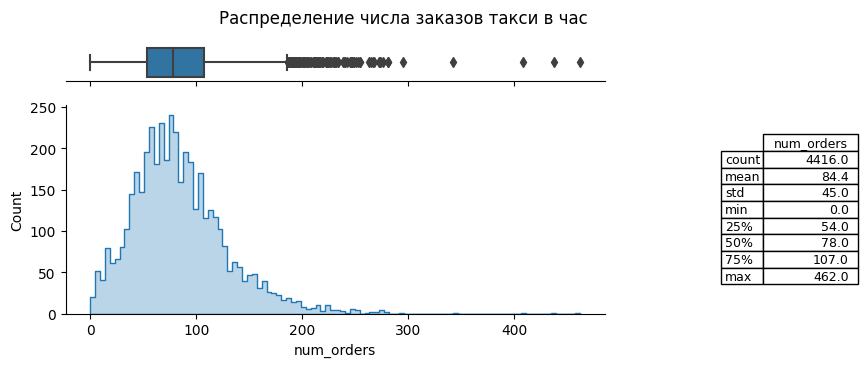

In [11]:
f, ax = plt.subplots(2,2, sharex=True, gridspec_kw={"height_ratios": (.15, .85), 
                                                    "width_ratios":  (.85, .15)}, figsize=(9,3.5))
sns.boxplot(x=data.num_orders, ax=ax[0,0])
sns.histplot(x=data.num_orders, bins=100, ax=ax[1,0], element="step",alpha=0.3)
table(data=data.describe().round(1), ax=ax[1,1], loc='right')

ax[0,1].remove(); ax[0,0].set(yticks=[], xlabel=None)
sns.despine(ax=ax[1,0]); sns.despine(ax=ax[0,0], left=True)
plt.axis('off'); f.suptitle('Распределение числа заказов такси в час'); plt.show()

In [12]:
(data.num_orders>250).sum() # кол-во рядов со значением числа заказов более 250

20

In [13]:
(data.num_orders>250).mean().round(4) # доля рядов со значением числа заказов более 250

0.0045

In [14]:
data.drop(data['num_orders'][data.num_orders>250].index, inplace=True) # удаление выбросов

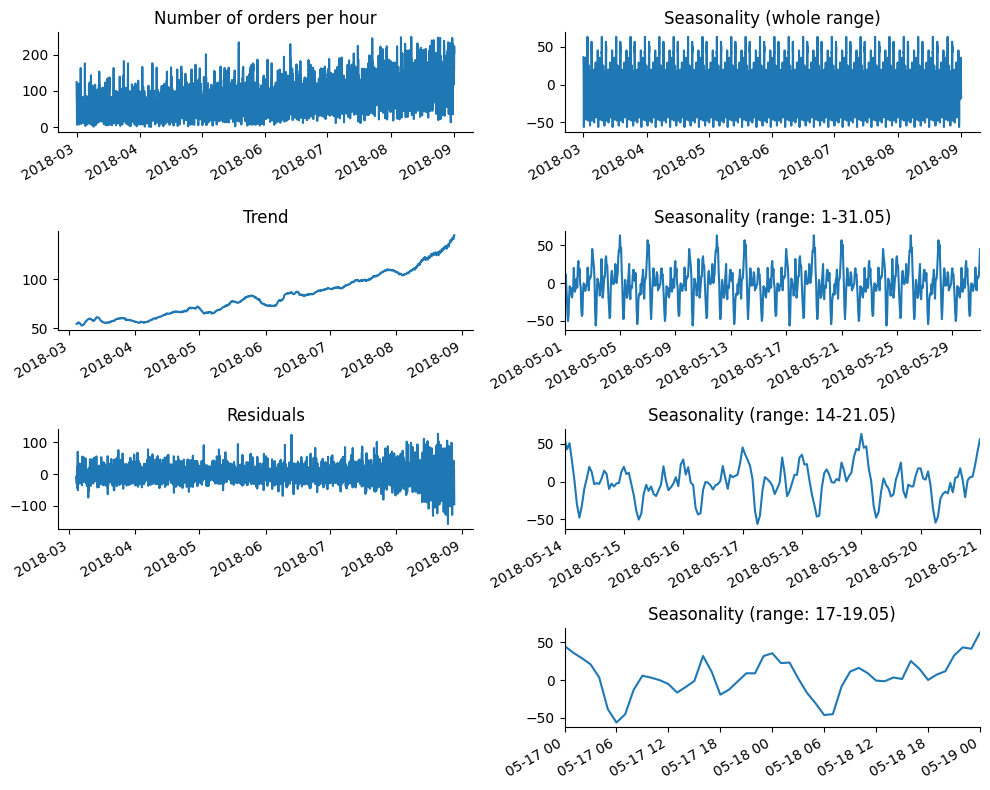

In [15]:
# декомпозиция временных рядов
decomposed = seasonal_decompose(data, period=24*7)
plt.figure(figsize=(10,8))

plt.subplot(421); data.num_orders.    plot(title='Number of orders per hour',    xlabel='')
plt.subplot(423); decomposed.trend.   plot(title='Trend',                        xlabel='')
plt.subplot(425); decomposed.resid.   plot(title='Residuals',                    xlabel='')
plt.subplot(422); decomposed.seasonal.plot(title='Seasonality (whole range)',    xlabel='')
plt.subplot(424); decomposed.seasonal.plot(title='Seasonality (range: 1-31.05)', xlabel='');plt.xlim('2018-05-01','2018-05-31')
plt.subplot(426); decomposed.seasonal.plot(title='Seasonality (range: 14-21.05)',xlabel='');plt.xlim('2018-05-14','2018-05-21')
plt.subplot(428); decomposed.seasonal.plot(title='Seasonality (range: 17-19.05)',xlabel='');plt.xlim('2018-05-17','2018-05-19')

plt.tight_layout(); sns.despine()

Общий тренд на увеличение числа заказов такси.<br>
Пиковое максимальное число заказов в полночь. Минимум - около 6 утра. Связано с числом прибывающих рейсов в определённое время.<br>
Наблюдаем рост residuals (шума) в последнем месяце наблюдений (август). Причины неясны. Возможно, начиная с августа, изменилось расписание прилёта. Таким образом появилось много заказов такси выбивающихся из общего тренда и сезонности.

### feature engineering

In [16]:
def make_features(data, max_lag, rolling_mean_size):
    '''создаёт признаки из разбитых частей даты, сдвинутых рядов, скользящего среднего'''
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [17]:
make_features(data, 10, 2) # создание дополнительных признаков

In [18]:
data.dropna(inplace=True)  # удаление рядов с пропусками

In [19]:
data.head(3)

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,,,
2018-03-01 10:00:00,64,3,1,3,10,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,51.5
2018-03-01 11:00:00,96,3,1,3,11,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,66.5
2018-03-01 12:00:00,30,3,1,3,12,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,80.0


In [20]:
round(1-data.shape[0]/4416, 4) # доля удалённых рядов

0.0068

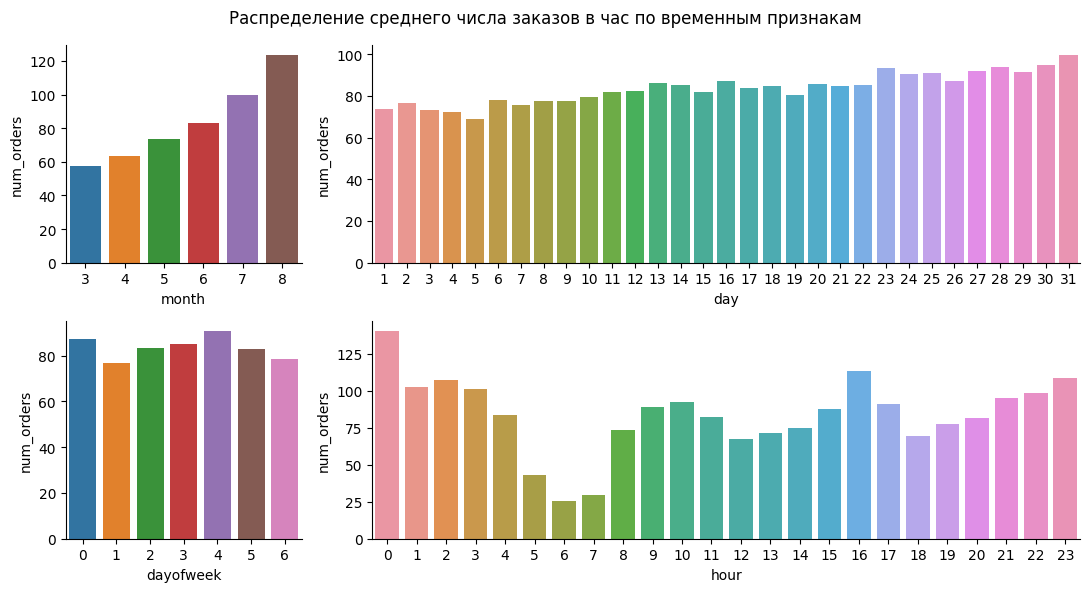

In [21]:
f,ax = plt.subplots(2,2, figsize=(11,6), gridspec_kw={"height_ratios": (.5, .5), "width_ratios": (0.25, 0.75)})

for feature, location in (('month',(0,0)), ('day',(0,1)), ('dayofweek',(1,0)), ('hour',(1,1))):
    sns.barplot(data=data.groupby(feature)['num_orders'].mean().reset_index(), x=feature, y='num_orders', ax=ax[location])

f.suptitle('Распределение среднего числа заказов в час по временным признакам'); sns.despine(); plt.tight_layout()

Распределения средних соответсвуют выводам сделанным по анализу декомпозиции временного ряда:
* 'month' - стабильный тренд на увеличение числа заказов с марта по август;
* 'dayofweek' - максимальное число заказов в понедельник и пятницу; связано с перелётами иногородних сотрудников между домом и офисом, а также отбытием/возвращением в/из отпуск(-а);
* 'hour' - максимальное число заказов в полночь, минимальное в 6 утра.

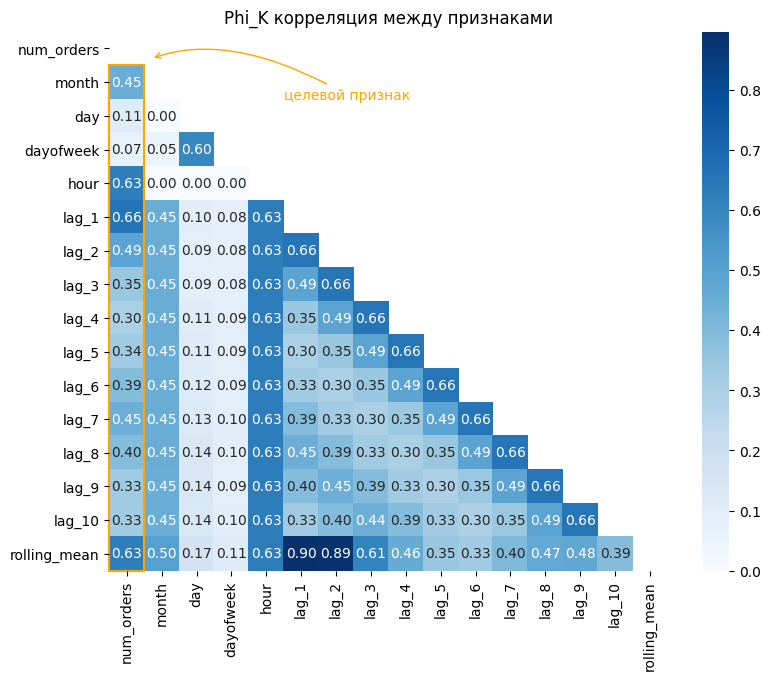

In [22]:
phik_corr = data.phik_matrix(interval_cols = ['num_orders', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 
                                              'lag_8', 'lag_9', 'lag_10', 'rolling_mean'])
matrix = np.tri(len(phik_corr)).T

plt.figure(figsize=(9,7))
ax=sns.heatmap(phik_corr, annot=True, mask=matrix, fmt='.2f', cmap='Blues')

ax.add_patch(Rectangle((0, 1), 1, data.shape[1]-1,  fill=False, edgecolor='orange', lw=1.5,clip_on=False))
ax.annotate('целевой признак', xy=(1.2, 0.8), xytext=(5, 2), color='orange',
             arrowprops=dict(arrowstyle="->", connectionstyle="angle3, angleA=-30, angleB=20", color = 'orange'))
plt.title('Phi_K корреляция между признаками'); plt.show()

* Целевой признак 'num_orders' больше всего зависит от 'hour', 'lag_1', 'rolling_mean', 'month', 'lag_7'.
* 'rolling_mean' мультиколлинеарен 'lag_1', 'lag_2'; что очевидно т.к. последние формируют скользящее.
* 'month' хорошо коррелирует с целевым признаком, но в нашей задаче этот признак будет бесполезен - рассматриваемый период меньше года, тестовая выборка по хронологии идёт позднее обучающей.

In [23]:
data.drop(['lag_1','lag_2','month'], axis=1, inplace=True) # удаление бесполезных признаков

## Обучение

### Split, Scaling, OHE

In [24]:
X = data.drop('num_orders', axis=1)            # разбиваем датасет на обучающую и тестовую выборки
Y = data.num_orders

X_train_, X_test_, Y_train, Y_test = train_test_split(X, Y, shuffle=False, test_size=0.1)

print(X_train_.shape, Y_train.shape)           # проверка размеров получившихся выборок
print(X_test_.shape,  Y_test.shape)

(3947, 12) (3947,)
(439, 12) (439,)


In [25]:
print(X_train_.index.max())                    # проверка не перепутана ли хронология train и test
print(X_test_.index.min())

2018-08-12 22:00:00
2018-08-12 23:00:00


In [26]:
features_num = ['lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'rolling_mean']
features_cat = ['day', 'dayofweek', 'hour']

scaler = StandardScaler()                                         # нормализация числовых признаков
scaler.fit(X_train_[features_num])
X_train_scaled = scaler.transform(X_train_[features_num])
X_test_scaled  = scaler.transform(X_test_[features_num])

encoder = OneHotEncoder(handle_unknown='ignore')                  # OHE категориальных признаков
encoder.fit(X_train_[features_cat])
X_train_ohe = encoder.transform(X_train_[features_cat]).toarray()
X_test_ohe  = encoder.transform(X_test_[features_cat]).toarray()

X_train = np.concatenate([X_train_scaled,X_train_ohe], axis=1)    # объединение числовых и категориальных
X_test  = np.concatenate([X_test_scaled, X_test_ohe],  axis=1)

print(X_train.shape)                                              # проверка размерности полученных выборок
print(X_test.shape)

(3947, 71)
(439, 71)


### LinearRegresion (Ridge)

In [27]:
model     = Ridge(random_state=random_fix)
ts_cv     = TimeSeriesSplit()
parametrs = {'alpha':  np.arange(0,1.1,0.1),
             'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}
grid = GridSearchCV(estimator = model, param_grid = parametrs, scoring = 'neg_root_mean_squared_error', cv = ts_cv)
grid.fit(X_train, Y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Ridge(random_state=12345),
             param_grid={'alpha': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'solver': ['auto', 'svd', 'cholesky', 'lsqr',
                                    'sparse_cg', 'sag', 'saga']},
             scoring='neg_root_mean_squared_error')

In [28]:
def grid_result(grid):
    '''выводит топ-10 результатов перебора; на входе GridSearchCV или RandomizedSearchCV'''
    result = pd.DataFrame(grid.cv_results_).sort_values('rank_test_score')\
         [['rank_test_score','params','mean_test_score']].set_index('rank_test_score')[:10]
    result['mean_test_score']*=-1
    
    display (result)
    
    print (f"Минимальное RMSE = {colored(grid.best_score_.round(3)*-1, 'cyan', attrs=['bold'])}\n\
    при гиперпараметрах {colored(grid.best_params_, 'cyan', attrs=['bold'])}.")

In [29]:
grid_result(grid)

,params,mean_test_score
rank_test_score,,
1,"{'alpha': 0.0, 'solver': 'saga'}",25.472853
2,"{'alpha': 0.0, 'solver': 'sag'}",25.472896
3,"{'alpha': 0.0, 'solver': 'sparse_cg'}",25.472938
4,"{'alpha': 0.0, 'solver': 'lsqr'}",25.473322
5,"{'alpha': 0.1, 'solver': 'svd'}",25.473569
6,"{'alpha': 0.1, 'solver': 'auto'}",25.473569
6,"{'alpha': 0.1, 'solver': 'cholesky'}",25.473569
8,"{'alpha': 0.1, 'solver': 'sparse_cg'}",25.473588
9,"{'alpha': 0.1, 'solver': 'saga'}",25.473700


Минимальное RMSE = 25.473
    при гиперпараметрах {'alpha': 0.0, 'solver': 'saga'}.


### DecisionTreeRegressor

In [30]:
%%time
model     = DecisionTreeRegressor(random_state=random_fix)
parametrs = {'max_depth':         range(2,16),
             'min_samples_split': range(2,8),
             'min_samples_leaf':  range(1,8)}
ts_cv = TimeSeriesSplit()
grid  = GridSearchCV(estimator = model, param_grid = parametrs, scoring = 'neg_root_mean_squared_error', cv=ts_cv)
grid.fit(X_train, Y_train)

CPU times: total: 35.5 s
Wall time: 35.4 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=DecisionTreeRegressor(random_state=12345),
             param_grid={'max_depth': range(2, 16),
                         'min_samples_leaf': range(1, 8),
                         'min_samples_split': range(2, 8)},
             scoring='neg_root_mean_squared_error')

In [31]:
grid_result(grid)

,params,mean_test_score
rank_test_score,,
1,"{'max_depth': 12, 'min_samples_leaf': 7, 'min_samples_split': 5}",28.679310
1,"{'max_depth': 12, 'min_samples_leaf': 7, 'min_samples_split': 2}",28.679310
1,"{'max_depth': 12, 'min_samples_leaf': 7, 'min_samples_split': 3}",28.679310
1,"{'max_depth': 12, 'min_samples_leaf': 7, 'min_samples_split': 4}",28.679310
1,"{'max_depth': 12, 'min_samples_leaf': 7, 'min_samples_split': 6}",28.679310
1,"{'max_depth': 12, 'min_samples_leaf': 7, 'min_samples_split': 7}",28.679310
7,"{'max_depth': 11, 'min_samples_leaf': 7, 'min_samples_split': 2}",28.697839
7,"{'max_depth': 11, 'min_samples_leaf': 7, 'min_samples_split': 3}",28.697839
7,"{'max_depth': 11, 'min_samples_leaf': 7, 'min_samples_split': 4}",28.697839


Минимальное RMSE = 28.679
    при гиперпараметрах {'max_depth': 12, 'min_samples_leaf': 7, 'min_samples_split': 2}.


### RandomForestRegressor

**Первое приближение**

In [32]:
%%time
model     = RandomForestRegressor(random_state=random_fix)
parametrs = {'max_depth':         range(2,16),
             'n_estimators':      range(20,201,20),
             'min_samples_split': range(2,8),
             'min_samples_leaf':  range(1,8)}
ts_cv = TimeSeriesSplit()
grid = RandomizedSearchCV(estimator = model, param_distributions = parametrs, scoring = 'neg_root_mean_squared_error', 
                          random_state = random_fix, n_iter = 5, cv = ts_cv)
grid.fit(X_train, Y_train)

CPU times: total: 34.5 s
Wall time: 34.5 s


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=RandomForestRegressor(random_state=12345),
                   n_iter=5,
                   param_distributions={'max_depth': range(2, 16),
                                        'min_samples_leaf': range(1, 8),
                                        'min_samples_split': range(2, 8),
                                        'n_estimators': range(20, 201, 20)},
                   random_state=12345, scoring='neg_root_mean_squared_error')

In [33]:
grid_result(grid)

,params,mean_test_score
rank_test_score,,
1,"{'n_estimators': 160, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 10}",25.730687
2,"{'n_estimators': 60, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 10}",25.803848
3,"{'n_estimators': 160, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_depth': 10}",25.849243
4,"{'n_estimators': 180, 'min_samples_split': 3, 'min_samples_leaf': 7, 'max_depth': 12}",26.034299
5,"{'n_estimators': 160, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 7}",26.796737


Минимальное RMSE = 25.731
    при гиперпараметрах {'n_estimators': 160, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 10}.


**Второе приближение**

In [34]:
%%time
model = RandomForestRegressor(random_state=random_fix)
parametrs = {'max_depth':         range(10,14),
             'n_estimators':      range(160,201,20),
             'min_samples_split': range(2,4),
             'min_samples_leaf':  range(2,4)}
ts_cv = TimeSeriesSplit()
grid = RandomizedSearchCV(estimator = model, param_distributions = parametrs, scoring = 'neg_root_mean_squared_error', 
                          random_state = random_fix, n_iter = 5, cv = ts_cv)
grid.fit(X_train, Y_train)

CPU times: total: 52.3 s
Wall time: 52.3 s


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=RandomForestRegressor(random_state=12345),
                   n_iter=5,
                   param_distributions={'max_depth': range(10, 14),
                                        'min_samples_leaf': range(2, 4),
                                        'min_samples_split': range(2, 4),
                                        'n_estimators': range(160, 201, 20)},
                   random_state=12345, scoring='neg_root_mean_squared_error')

In [35]:
grid_result(grid)

,params,mean_test_score
rank_test_score,,
1,"{'n_estimators': 180, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 13}",25.251864
2,"{'n_estimators': 180, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 12}",25.311009
3,"{'n_estimators': 160, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 11}",25.444887
4,"{'n_estimators': 200, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 12}",25.458594
5,"{'n_estimators': 160, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 11}",25.549060


Минимальное RMSE = 25.252
    при гиперпараметрах {'n_estimators': 180, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 13}.


**Третье приближение**

In [36]:
%%time
model     = RandomForestRegressor(random_state=random_fix)
parametrs = {'max_depth':         [13,14],
             'n_estimators':      [180,200],
             'min_samples_split': [3],
             'min_samples_leaf':  [2]}
ts_cv = TimeSeriesSplit()
grid  = GridSearchCV(estimator = model, param_grid = parametrs, scoring = 'neg_root_mean_squared_error', cv = ts_cv)
grid.fit(X_train, Y_train)

CPU times: total: 51.3 s
Wall time: 51.3 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(random_state=12345),
             param_grid={'max_depth': [13, 14], 'min_samples_leaf': [2],
                         'min_samples_split': [3], 'n_estimators': [180, 200]},
             scoring='neg_root_mean_squared_error')

In [37]:
grid_result(grid)

,params,mean_test_score
rank_test_score,,
1,"{'max_depth': 14, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 180}",25.202807
2,"{'max_depth': 14, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 200}",25.217645
3,"{'max_depth': 13, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 180}",25.251864
4,"{'max_depth': 13, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 200}",25.271061


Минимальное RMSE = 25.203
    при гиперпараметрах {'max_depth': 14, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 180}.


### LightGBM

In [38]:
def light_gbm_cv(depth, iterations, learning_rate):
    '''с помощью кросс-валидации возвращает RMSE_min и номер итерации при RMSE_min; 
       на входе глубина дерева, максимальное кол-во итераций, learning_rate'''

    train_data = lgb.Dataset(X_train, label=Y_train)
    ts_cv = TimeSeriesSplit()
    param = {'objective':            'regression',
             'metric':               'rmse',
             'learning_rate':        learning_rate,
             'max_depth':            depth,
             'num_leaves':           1000,
             'early_stopping_round': 10,
             'verbose':              -1,
             'random_state':         random_fix}
    
    scores = pd.DataFrame(lgb.cv(param, 
                                 train_data,
                                 num_boost_round=iterations,
                                 folds=ts_cv,
                                 stratified=False))
    return scores['rmse-mean'].min().round(3), scores['rmse-mean'].idxmin()

In [39]:
def gridsearch_boost(algorithm, depth, iterations, learning_rate):
    '''На входе: функция бустинга, сделанная ранее (возвращает RMSE_min и iteration); range/list глубин дерева, максимальных 
       чисел итераций, обучающих к-ов. Ф-ия перебирает в циклах все варианты и выдаёт лучшие RMSE и гиперпараметры'''
    
    result = pd.DataFrame(columns=['depth', 'learning_rate', 'iteration', 'RMSE'])
    for d in depth:
        for lr in learning_rate:
            for i in iterations:
                rmse_iter = algorithm(d, i, lr)
                result = pd.concat([result, pd.DataFrame([[d, lr, rmse_iter[1], rmse_iter[0]]],
                                                         columns=['depth', 'learning_rate', 'iteration', 'RMSE'])])
              
                print(f"Отработка кода: depth = {d}, learning_rate = {lr}, iteration = {i}   ", end="\r")
    print(' '*70, end="\r")  # закрашивает табло хода итераций
    
    result = result.sort_values('RMSE').reset_index(drop=True)
    print (f"Минимальное RMSE = {colored(result.loc[0]['RMSE'], 'cyan', attrs=['bold'])}\n\
           при гиперпараметрах {colored(result.loc[0].drop('RMSE').to_dict(), 'cyan', attrs=['bold'])}.")
    
    display(result[:10])

In [40]:
%%time
gridsearch_boost(light_gbm_cv, range(2,10), [1000], [0.1, 0.01])

Минимальное RMSE = 24.705                                
           при гиперпараметрах {'depth': 2, 'learning_rate': 0.1, 'iteration': 260}.


,depth,learning_rate,iteration,RMSE
0,2,0.10,260,24.705
1,3,0.10,182,24.854
2,4,0.10,119,24.875
3,4,0.01,996,25.040
4,5,0.01,999,25.100
5,5,0.10,102,25.171
6,6,0.10,89,25.293
7,8,0.01,669,25.301
8,3,0.01,998,25.305
9,6,0.01,739,25.308


CPU times: total: 1min 4s
Wall time: 49.1 s


### CatBoost

In [41]:
def catboost_cv(depth, iterations, learning_rate):
    '''с помощью кросс-валидации возвращает RMSE_min и номер итерации при RMSE_min; 
       на входе глубина дерева, максимальное кол-во итераций, learning_rate'''
    cv_dataset = Pool(data =X_train,
                      label=Y_train)
    params = {'iterations':            iterations,
              'early_stopping_rounds': 10,
              'learning_rate':         learning_rate,
              'depth':                 depth,
              'loss_function':         'RMSE',
              'logging_level':         'Silent'}
    ts_cv = TimeSeriesSplit()
    scores = cv(cv_dataset,
                params,
                folds = ts_cv)
    return scores['test-RMSE-mean'].min().round(3), scores['test-RMSE-mean'].idxmin()

In [42]:
%%time
gridsearch_boost(catboost_cv, range(2,10), [1000], [0.1, 0.01])

Минимальное RMSE = 24.55                                 
           при гиперпараметрах {'depth': 4, 'learning_rate': 0.1, 'iteration': 305}.


,depth,learning_rate,iteration,RMSE
0,4,0.10,305,24.550
1,3,0.10,266,24.623
2,5,0.10,270,24.637
3,6,0.10,199,24.898
4,2,0.10,291,25.097
5,7,0.10,191,25.281
6,6,0.01,999,25.389
7,5,0.01,999,25.453
8,7,0.01,999,25.584
9,8,0.10,173,25.615


CPU times: total: 15min 13s
Wall time: 1min 51s


<a id= 'pivot'></a>
### Сводная таблица

| Algorithm | Parameters | RMSE |
| --- | --- | --- |
| LinearRegression (Ridge) | 'alpha': 0.0, 'solver': 'saga' | 25.473 |
| DecisionTreeRegressor | 'max_depth': 12, 'min_samples_leaf': 7, 'min_samples_split': 2 | 28.679 |
| RandomForestRegressor | 'max_depth': 14, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 180 | 25.203 |
| LightGBM | 'depth': 2, 'learning_rate': 0.1, 'iteration': 260 | 24.705 |
| CatBoost |  'depth': 4, 'learning_rate': 0.1, 'iteration': 305 | 24.550 |

Наименьшее RMSE показал CatBoost. Попробуем данную модель на тестовой выборке.

## Тестирование

### Проверка лучшей модели на тестовой выборке

In [43]:
# рассчёт RMSE на тестовой выборке с помощью CatBoost
model = CatBoostRegressor(iterations =            350,
                          early_stopping_rounds = 10,
                          learning_rate =         0.1,
                          depth =                 4,
                          loss_function =         'RMSE',
                          logging_level =         'Silent')
model.fit(X_train, Y_train)
root_mean_squared_error(Y_test, model.predict(X_test)).round(3)

34.946

### Feature importance

In [44]:
def collapse_list(importances_ohe, features):
    '''сокращаяет размер Series, суммируя значения схожих индексов; список уникальных индексов передаётся вторым аргументом'''
    importances = []
    for f in features:
        importances.append(importances_ohe[list(map(bool,importances_ohe.index.str.find(f)+1))].sum())
    return pd.Series(importances, features).sort_values(ascending=False)

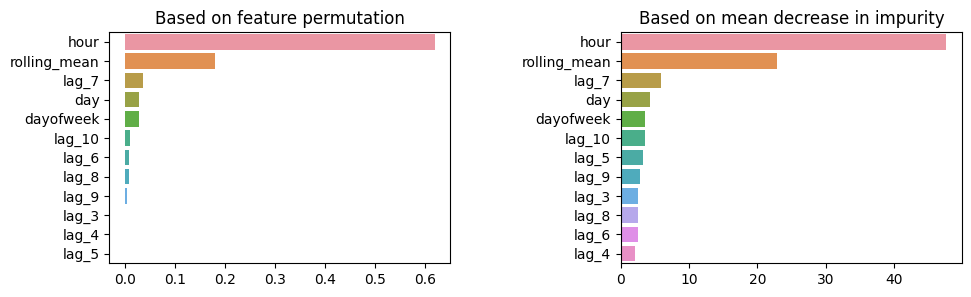

In [45]:
f, (ax_1, ax_2) = plt.subplots(1,2,figsize=(11,3),gridspec_kw={"wspace": 0.5})

result_1 = permutation_importance(model, X_test, Y_test, random_state=random_fix)
importances_1 = pd.Series(result_1.importances_mean, index=features_num+encoder.get_feature_names_out().tolist())
importances_1 = collapse_list(importances_1,X.columns)
sns.barplot(x = importances_1.sort_values(ascending=False),
            y = importances_1.sort_values(ascending=False).index, ax=ax_1).set(title='Based on feature permutation')

importances_2 = model.feature_importances_
importances_2 = pd.Series(importances_2, index=features_num+encoder.get_feature_names_out().tolist())
importances_2 = collapse_list(importances_2,X.columns)
sns.barplot(x=importances_2.sort_values(ascending=False),
                     y=importances_2.sort_values(ascending=False).index, ax=ax_2).set(
                     title='Based on mean decrease in impurity'); plt.show()

Feature importance based on feature permutation - считается более достоверным способом определения.

## Вывод

Анализ данных
* Исходный датасет, размером 26496 строк, содержит информацию о заказах с разбивкой по 10 минут. Проведено ресемплирование по одному часу. Полученный размер 4416 временных рядов.
* Рассматриваенмый временной период от 01.03.2018 до 31.08.2018.
*'month' - стабильный тренд на увеличение числа заказов с марта по август;<br>
'dayofweek' - максимальное число заказов в понедельник и пятницу; связано с перелётами иногородних сотрудников между домом и офисом, а также отбытием/возвращением в/из отпуск(-а);<br>
'hour' - максимальное число заказов в полночь, минимальное в 6 утра.
* Наблюдаем рост residuals (шума данных) в последнем месяце наблюдений (август). Причины неясны. Возможно, начиная с августа, изменилось расписание прилёта. Таким образом появилось много заказов такси выбивающихся из общего тренда и сезонности.

Machine learning
* Построено 5 моделей ([сводная таблица в п.3.8](#pivot)).<br>
Лучший результат RMSE, равный 34.946 на тестовой выборке, у алгоритма CatBoost с гиперпараметрами {'depth': 4, 'learning_rate': 0.1, 'iteration': 350}.
* Наиболее весомые признаки: время и скользящее среднее с размером окна 3 дня (за исключением текущего); далее с большим отрывом идут дата, день недели и число заказов 7 часов назад.